In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle
import math

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50_unique.jsonl"
device = torch.device("mps")
prefix = 'pickle'

In [2]:
# https://github.com/ipython-contrib/jupyter_contrib_nbextensions/pull/1663

In [3]:
from io import BytesIO

def fix(map_loc):
    # Closure rather than a lambda to preserve map_loc 
    return lambda b: torch.load(BytesIO(b), map_location=map_loc)

class MappedUnpickler(pickle.Unpickler):
    # https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219

    def __init__(self, *args, map_location='cpu', **kwargs):
        self._map_location = map_location
        super().__init__(*args, **kwargs)

    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return fix(self._map_location)
        else: 
            return super().find_class(module, name)

def mapped_loads(s, map_location='cpu'):
    bs = BytesIO(s)
    unpickler = MappedUnpickler(bs, map_location=map_location)
    return unpickler.load()

In [4]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [5]:
# load questions (to be removed)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [6]:
import os
import pickle
from copy import copy, deepcopy
import zipfile

pre_keys = ['pre_output_proba_topn',
 'pre_output_proba_topk',
 'pre_output_true_entropies',
 'pre_output_layers_kl']

run = 0
outlist = []

for file in os.listdir(prefix):
    if file.endswith('zip'):
        print(file)
        archive = zipfile.ZipFile(os.path.join(prefix, file), 'r')
        for pid, single_file in enumerate(tqdm(archive.filelist)):
            
            if single_file.filename.startswith('_') or single_file.filename.startswith('.'): continue
                
            # item = pickle.loads(archive.read(single_file.filename))
            item = mapped_loads(archive.read(single_file.filename))
            
            for i, _ in enumerate(item["post_output_sequences"]):
                
                item_ = copy(item)
                item_["post_output_sequences"] = item["post_output_sequences"][i]
                
                item_["post_output_proba_topn"] = item["post_output_proba_topn"][i]
                item_["post_output_proba_topk"] = item["post_output_proba_topk"][i]
                item_["post_output_true_entropies"] = item["post_output_true_entropies"][i] 

                item_["post_output_layers_kl"] = item["post_output_layers_kl"][i]
                item_["transition_scores_s"] = item["transition_scores_s"][i]
                item_["transition_scores_l"] = item["transition_scores_l"][i]

                item_["run"] = run + i
                
                outlist.append(item_)
                
                # whatever is generated for pre_ is propagated only to the first run
                if i == 0:
                    for k in pre_keys: item.pop(k, None)
      
        run = run + i + 1 # next zip file

len(outlist)

gemma-9b-complete.zip


100%|███████████████████████████████████████| 1477/1477 [00:43<00:00, 34.30it/s]


14770

In [7]:
# prefix, model_name = './tablellama-complete/', "osunlp/TableLlama"
# prefix, model_name = './gemma-9b-complete/', "google/gemma-2-9b-it"

model_name = item['args']['model_name'] # get model from last processed item

if model_name.startswith("osunlp"):
    config = transformers.AutoConfig.from_pretrained(model_name)

    orig_ctx_len = getattr(config, "max_position_embeddings", None)
    context_size = 8192
    if orig_ctx_len and context_size > orig_ctx_len:
            scaling_factor = float(math.ceil(context_size / orig_ctx_len))
            config.rope_scaling = {"type": "linear", "factor": scaling_factor}

    tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                              model_max_length=(context_size if context_size > orig_ctx_len else orig_ctx_len),
                                              padding_side="left", 
                                              use_fast=False)

else:
    config = transformers.AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

### check output against ground truth

In [8]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

pdbg = None

for idx, p in enumerate(outlist):
    print(idx, end='\r')
    c+=1
    pdbg = p
    
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    
    # replacement due to tablellama "hallucinations"
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    if len(a) < 1: 
        print("SOMETHING WENT HORRIBLY WRONG, GIVING UP")
        break

    b = p['output'].lower().strip()
    # correct
    correct = False
    hallucinated = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')

    truth.append((p['run'], p['pid'], correct, hallucinated))
    outseq.append((p['run'], p['pid'], a, post_output_sequences, b))

CPU times: user 25.7 s, sys: 2.45 s, total: 28.1 s
Wall time: 34 s


In [9]:
len(inputs.input_ids[0]), len(post_output_sequences[0])

(2128, 2157)

In [10]:
# true, hallucinated, counted
# (3702, 26, 5120) tablellama old
# (11190, 880, 14770) gemma 9b
t, h, c

(11243, 802, 14770)

In [11]:
# correct answers rate, hannucinated answers rate
t/c, h/c

(0.7612051455653351, 0.05429925524712254)

In [12]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated'])

In [13]:
corec = truth.groupby('pid').correct.mean()

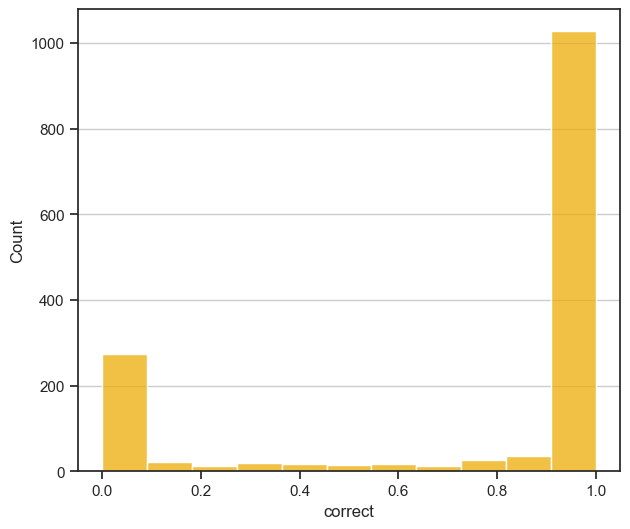

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corec, bins=corec.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

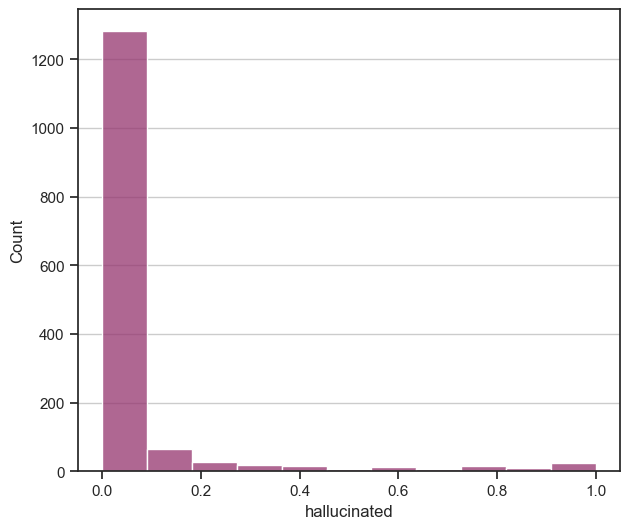

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(truth.groupby('pid').hallucinated.mean(), bins=corec.nunique(), color=Prism_10.mpl_colors[8])

ax.yaxis.grid(True)

plt.show()

In [16]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer'])
answers.answer = answers.answer.str[:-1]

In [17]:
# min and max number of unique answers
answers.groupby('pid').answer.nunique().min(), answers.groupby('pid').answer.nunique().max()

(1, 10)

In [18]:
# wrong answers

import numpy as np
def fun (a,b):
    return a.startswith(b) or b.startswith(a)

foon = np.vectorize(fun)
aoh = pd.Series(foon(answers.answer, answers.right_answer), index=answers.index)

answers[~aoh]

,run,pid,answer,answer_seq,right_answer
40,0,1461,"<new haven (part), west haven (part)","[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...","<new haven [desc] city in connecticut, united ..."
41,1,1461,"<new haven (part), west haven (part)","[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...","<new haven [desc] city in connecticut, united ..."
42,2,1461,"<new haven (part), west haven (part)","[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...","<new haven [desc] city in connecticut, united ..."
43,3,1461,"<new haven (part), west haven (part)","[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...","<new haven [desc] city in connecticut, united ..."
44,4,1461,"<new haven (part), west haven (part)","[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...","<new haven [desc] city in connecticut, united ..."
...,...,...,...,...,...
14709,9,764,"<"" rockefeller street "" [desc] single [type] s...","[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<rockefeller street [desc] single [type] single>
14752,2,518,<madre de dios province [desc] province of bol...,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<madre de dios [desc] department of peru [type...
14753,3,518,<madre de dios province [desc] province of per...,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<madre de dios [desc] department of peru [type...
14755,5,518,<madre de dios province [desc] province of bol...,"[[2, 33501, 603, 671, 14239, 674, 19306, 476, ...",<madre de dios [desc] department of peru [type...


### sequence components alignment
### (build "segments" for each sequence)

In [19]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [87]:
%%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])
    
    # this is the generated sequence
    output_seq = p['post_output_sequences'][0]
    
    # overall prompt sequence
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    # subsequences TODO FIX THESE
    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla += "\n\n### Response:"
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    # skipped the last token in pre_
    checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 2, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq) - 1 , len(output_seq) - 2, 'generated')) # assume everything else is generated    
    # before caching dirty trick
    # checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    # checks.append((run, pid, len(prompt_seq), len(output_seq) - 1, 'generated')) # assume everything else is generated
    
    #print(len(prompt_seq), len(output_seq) - 1)
    #if idx>8: break
    break

CPU times: user 13.4 ms, sys: 2.26 ms, total: 15.7 ms
Wall time: 14.5 ms


In [88]:
# check the checks (must be False)
'False' in checks

False

In [89]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [90]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [91]:
segments['length'] = segments.end - segments.start + 1

In [92]:
segments[:10]

,run,pid,start,end,segment,seq,length
0,0,1311,0,34,preamble,0,35
1,0,1311,35,128,instruction,1,94
2,0,1311,129,929,input,2,801
3,0,1311,930,1938,question,3,1009
4,0,1311,1940,1996,postilla,4,57
5,0,1311,1997,2015,generated,5,19


In [120]:
p["instruction"]

'This is an entity linking task. The goal for this task is to link the selected entity mention in the table cells to the entity in the knowledge base. You will be given a list of referent entities, with each one composed of an entity name, its description and its type. Please choose the correct one from the referent entity candidates. Note that the Wikipedia page, Wikipedia section and table caption (if any) provide important information for choosing the correct referent entity.'

In [113]:
# debug
p = outlist[0]
prompt = generate_prompt(p["instruction"], p["question"], p["input"])
prompt_seq = tokenizer(prompt, return_tensors="pt")

In [114]:
myids = segments[(p['pid'] == segments['pid']) & (p['run']==0) & (segments['segment']=='preamble')]

tokens = tokenizer.convert_ids_to_tokens(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1])
' '.join([t.replace('▁', '') for t in tokens])

'<bos> Below is an instruction that describes a task , paired with an input that provides further context . Write a response that appropriately completes the request . \n\n ### Instruction : \n This is'

In [115]:
myids = segments[(p['pid'] == segments['pid']) & (p['run']==0) & (segments['segment']=='instruction')]

tokens = tokenizer.convert_ids_to_tokens(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1])
' '.join([t.replace('▁', '') for t in tokens])

'an entity linking task . The goal for this task is to link the selected entity mention in the table cells to the entity in the knowledge base . You will be given a list of refer ent entities , with each one composed of an entity name , its description and its type . Please choose the correct one from the refer ent entity candidates . Note that the Wikipedia page , Wikipedia section and table caption ( if any ) provide important information for choosing the correct refer ent entity . \n\n'

In [116]:
myids = segments[(p['pid'] == segments['pid']) & (p['run']==0) & (segments['segment']=='input')]

tokens = tokenizer.convert_ids_to_tokens(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1])
' '.join([t.replace('▁', '') for t in tokens])

"### Input : \n [ TLE ]  2 0 1 1 Nationwide Tour . Schedule [ TAB ] col : | date | tournament | location | winner | ow gr points | notes | row  0 : | Feb  2 7 | Panama Claro Championship | Panama | Mat hew Gog gin ( 3 )| 1 4 || row  1 : | Mar  6 | Pacific Rub iales Bogotá Open | Colombia | Brend en Papp as ( n / a )| 1 0 | Official money , unofficial win - tournament shortened to  3 6 holes by weather | row  2 : | Mar  2 7 | Chi tima cha Louisiana Open | Louisiana | Brett Wetter ich ( 3 )| 1 4 || row  3 : | Apr  1 7 | Fresh Express Classic at TPC Stone bra e | California | Daniel Chopra ( 3 )| 1 4 || row  4 : | May  1 | South Georgia Classic | Georgia | Ted Potter , Jr . ( 1 )| 1 4 | Won as a Monday qualifier | row  5 : | May  8 | Stadion Classic at U GA | Georgia | Russell Henley ( am ) ( 1 )| 1 4 | Won as an amateur | row  6 : | May  2 2 | BMW Charity Pro - Am | South Carolina | Garth Mul roy ( 2 )| 1 4 || row  7 : | Jun  5 | Mel wood Prince George ' s County Open | Maryland | Steve 

In [117]:
myids = segments[(p['pid'] == segments['pid']) & (p['run']==0) & (segments['segment']=='question')]

tokens = tokenizer.convert_ids_to_tokens(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1])
' '.join([t.replace('▁', '') for t in tokens])

"### Question : \n The selected entity mention in the table cell is : ' Steve Wheat croft ( 1 ) '. The column name for ' Steve Wheat croft ( 1 )' is col 3 . The refer ent entity candidates are :< Wheat croft [ DESC ] family name [ TYPE ] family name >, < Steve Holt [ DESC ] None [ TYPE ] fictional human >, < Wheat croft House [ DESC ] house in Ho oton Pag nell , Doncaster , South Yorkshire , UK [ TYPE ] house >, < Wheat croft [ DESC ] building in Frit well , Cher well , Oxfordshire , UK [ TYPE ] building >, < The Wheat croft Collection [ DESC ] None [ TYPE ] collecting >, < Steve Hewlett [ DESC ] Wikimedia dis ambiguation page [ TYPE ] Wikimedia human name dis ambiguation page >, < Sc umbag Steve [ DESC ] Internet meme and fictional character [ TYPE ] fictional human >, < Steve [ DESC ] character in The West Wing [ TYPE ] fictional human >, < Steve [ DESC ] painting by Barkley L . Hendricks [ TYPE ] painting >, < Steve Hugh [ DESC ] None [ TYPE ] scholarly article >, < Steve [ DESC ] p

In [118]:
myids = segments[(p['pid'] == segments['pid']) & (p['run']==0) & (segments['segment']=='postilla')]

tokens = tokenizer.convert_ids_to_tokens(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1])
' '.join([t.replace('▁', '') for t in tokens])

'just a candidate , selected from the provided refer ent entity candidates list , and nothing else . The selected candidate must be reported verbatim from the list provided as input . Each candidate in the list is enclosed between < and > and reports [ DESC ] and [ TYPE ] information . \n\n ### Response'

In [119]:
myids = segments[(p['pid'] == segments['pid']) & (p['run']==0) & (segments['segment']=='generated')]

tokens = tokenizer.convert_ids_to_tokens(prompt_seq["input_ids"][0][myids.start.iloc[0]:myids.end.iloc[0]+1])
' '.join([t.replace('▁', '') for t in tokens])

':'

### segment description

In [29]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,41.000000,0.000000,41,41,0.016261,0.016261
2,instruction,1,95.000000,0.000000,95,95,0.037679,0.053940
1,input,2,1017.526084,655.185256,139,3644,0.403571,0.457511
5,question,3,1278.585599,240.616218,278,2803,0.507112,0.964624
3,postilla,4,64.000000,0.000000,64,64,0.025384,0.990007
0,generated,5,25.194710,5.691496,14,57,0.009993,1.000000


<Axes: xlabel='length', ylabel='Count'>

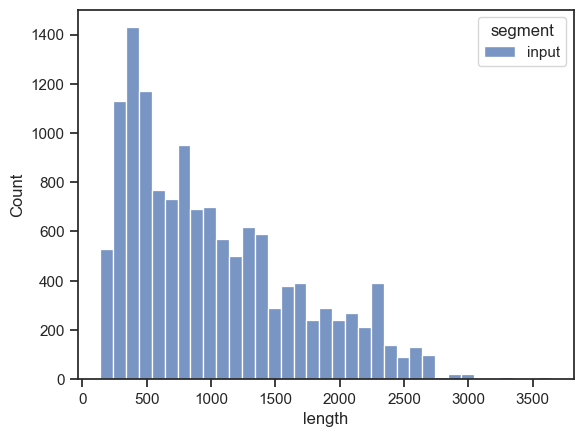

In [30]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

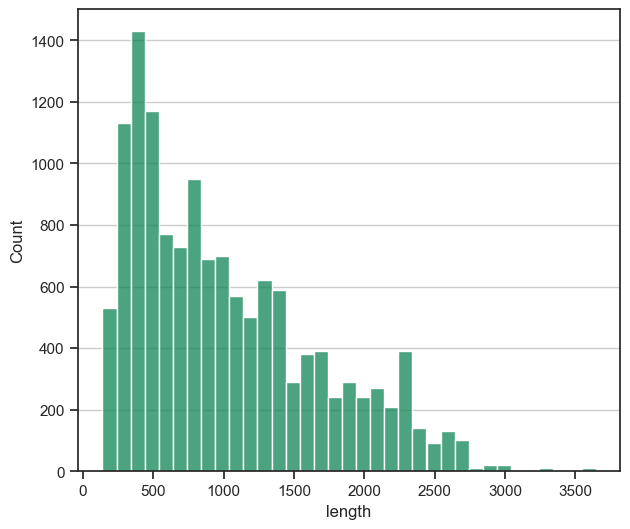

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(segments[segments.segment=='input'], x='length', color=Prism_10.mpl_colors[3], multiple='dodge', binwidth=100)

ax.yaxis.grid(True)

plt.show()

In [32]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

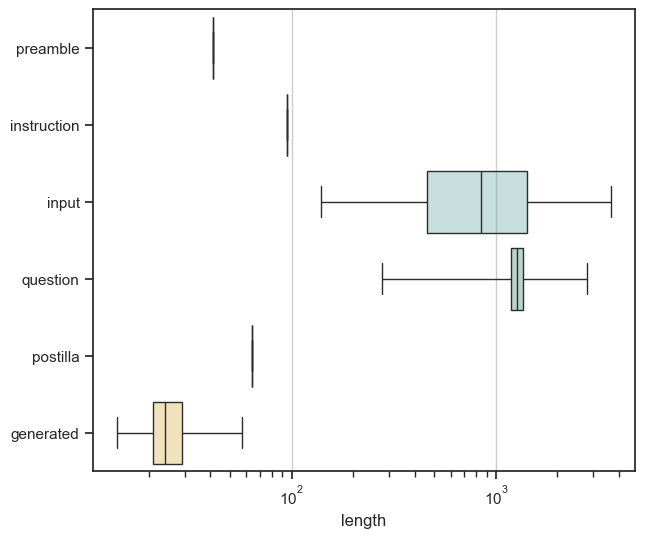

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(
    segments, x="length", y="segment", hue="segment",
    whis=[0, 100], palette=[b[2] for b in background_regions]
)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax.xaxis.grid(True)
ax.set(ylabel="")

plt.show()

### collect observables

In [34]:
# outlist[0]['post_output_layers_kl'] ha dimensione n layer x m token generati
# outlist[0]['transition_scores_s'] ha dimensione m token generati

In [35]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    
    # append all forward data (for run0 only)   
    if 'pre_output_proba_topn' in p:
        transpose_kl_pre = list(map(list, zip(*p['pre_output_layers_kl'])))
        for j, pp in enumerate(p['pre_output_proba_topn']):
            shapes.append((run,pid,j,'prompt',
                               len(pp['top_n_indices']),
                               p['pre_output_true_entropies'][j],
                               max(pp['top_n_probs']),
                               None,
                               None,
                               transpose_kl_pre[j],
                               None))
            print(max(pp['top_n_probs']), max(pp['top_k_probs']))
    
    
    transpose_kl = list(map(list, zip(*p['post_output_layers_kl'])))
    # transpose_iou = list(map(list, zip(*p['post_output_layers_iou'])))
    # append all generation data
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs']),
                           p['transition_scores_s'][jj],
                           p['transition_scores_l'][jj],
                           transpose_kl[jj],
                           None))

KeyError: 'top_k_probs'

In [36]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp', 'trans_s', 'trans_l', 'logitlens_kl', 'logitlens_iou'])

CPU times: user 389 µs, sys: 34 µs, total: 423 µs
Wall time: 394 µs


In [37]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

False

In [38]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

,run,pid,tok,shape,true_ent,maxp
count,1.0,1.0,1.0,1.0,1.000000,1.000000
mean,0.0,1752.0,0.0,1.0,9.367188,0.012024
std,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,1752.0,0.0,1.0,9.367188,0.012024
25%,0.0,1752.0,0.0,1.0,9.367188,0.012024
50%,0.0,1752.0,0.0,1.0,9.367188,0.012024
75%,0.0,1752.0,0.0,1.0,9.367188,0.012024
max,0.0,1752.0,0.0,1.0,9.367188,0.012024


In [39]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

,run,pid,tok,shape,true_ent,maxp
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
print(m.shape, d.shape)
m = m[(m.tok >= m.start) & (m.tok <= m.end)] # segment indices are non-overlapping
print(m.shape) # misses last token for every run0

(6, 16) (1, 11)
(1, 16)
CPU times: user 4.72 ms, sys: 1.52 ms, total: 6.23 ms
Wall time: 5.02 ms


In [41]:
# invalidated by caching without the last token
# did we merge all the tokens to their segments (must be True)
# d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

In [42]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

False

In [43]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

### check variances

In [44]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

nan

In [45]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

nan

In [46]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

nan

In [47]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

nan

In [48]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

nan

In [49]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

nan

In [50]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

nan

In [51]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

nan

In [52]:
if True:
    myoutdict = {'truth': truth, 'segments': segments, 'm': m, 'answers': answers, 'model_name': model_name}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [53]:
!ls -larth | grep preprocessed

-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--   1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--@  1 bono  staff   105M Apr  3 09:32 preprocessed.pickle


## Load preprocessed

In [134]:
%%time

with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

CPU times: user 12.9 s, sys: 20.3 s, total: 33.2 s
Wall time: 42.6 s


In [108]:
NUM_BINS = 100

99


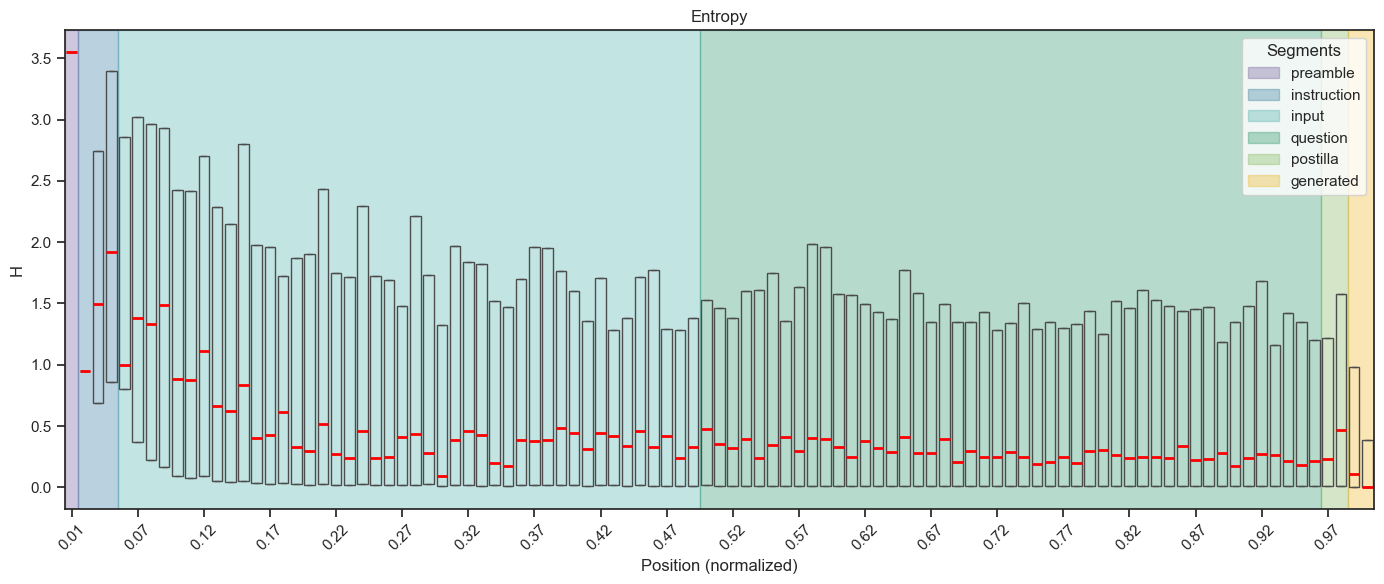

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
# ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [76]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

100


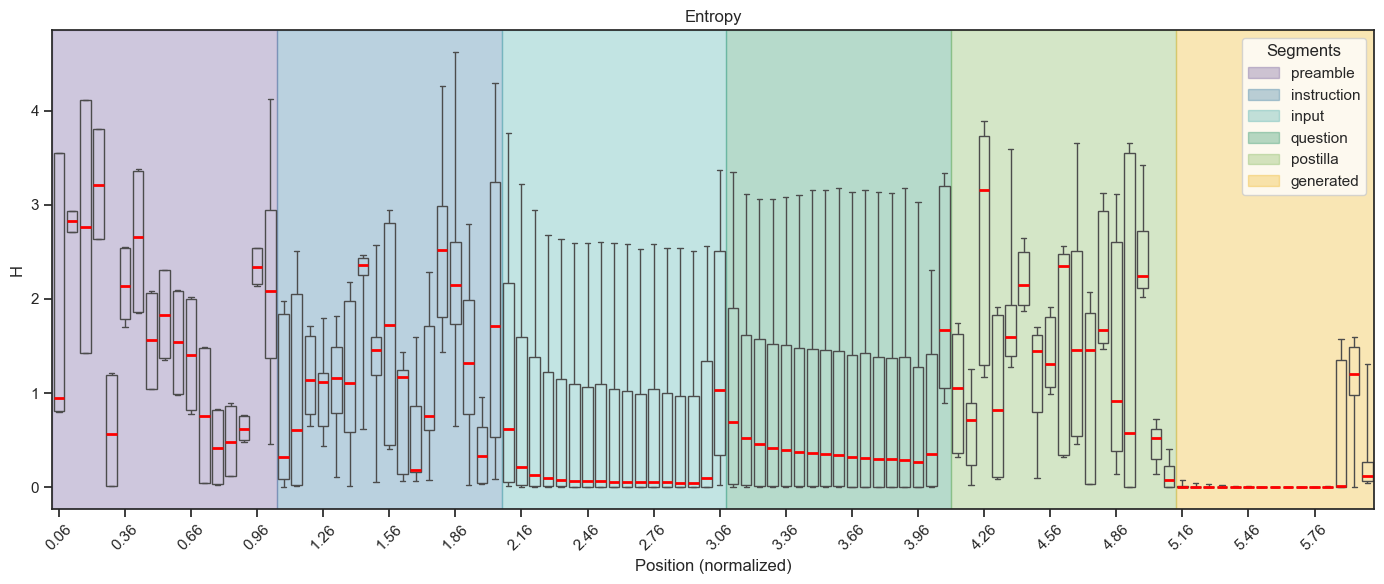

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [78]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

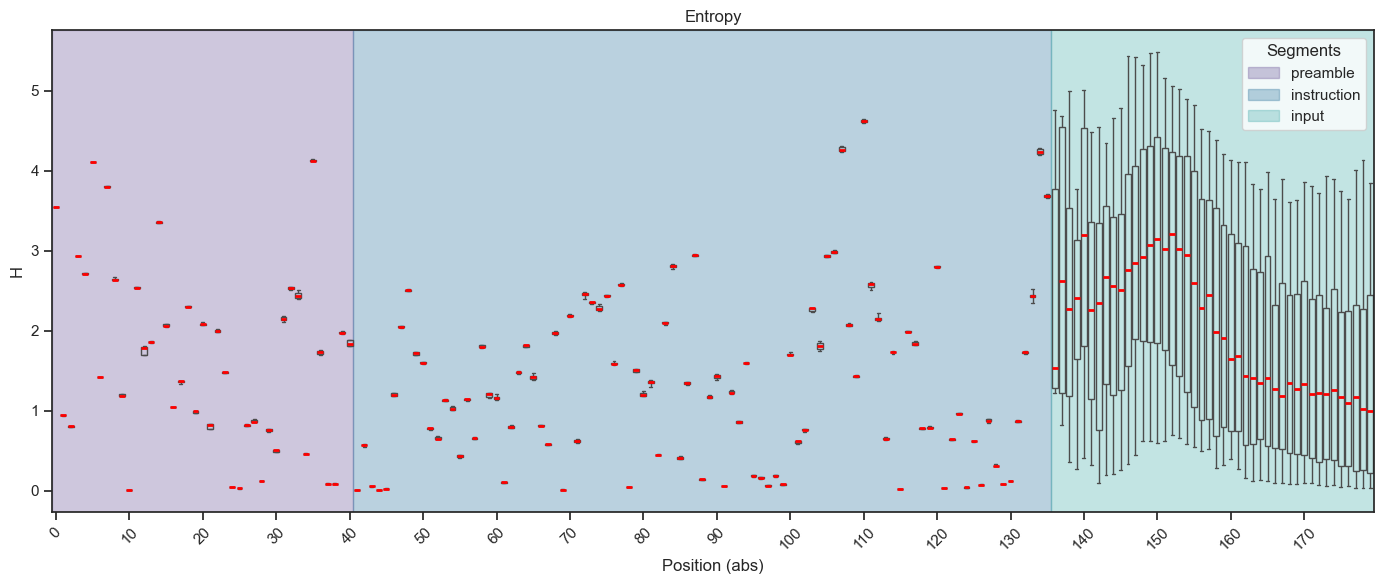

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [81]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

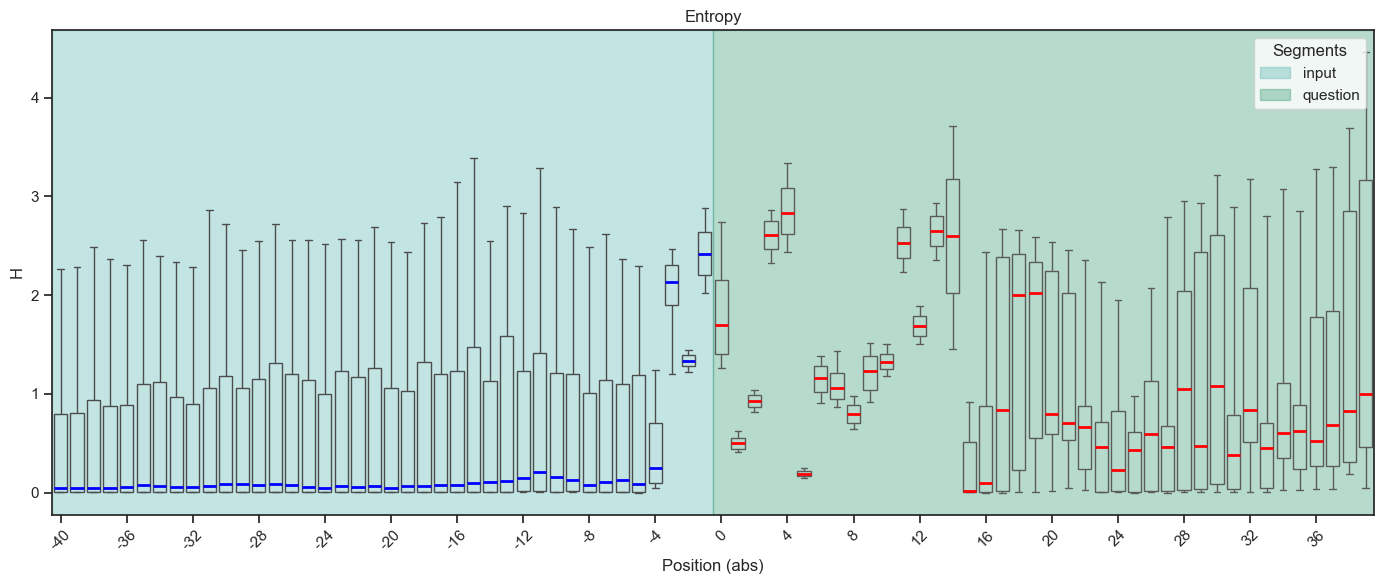

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [83]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

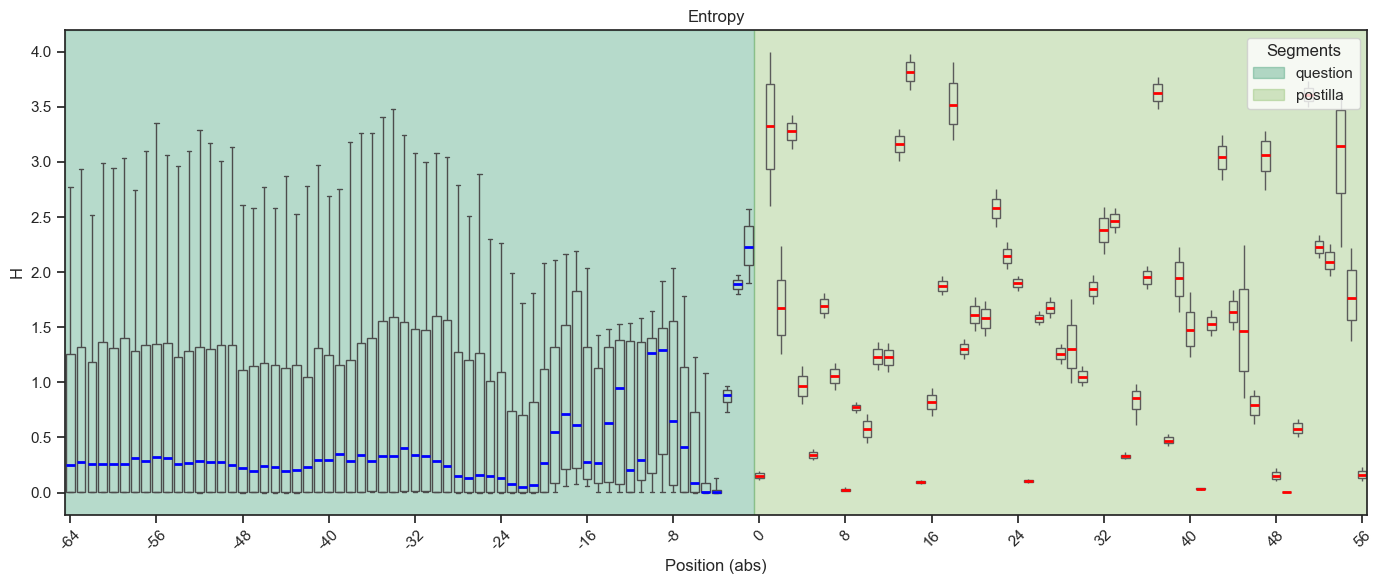

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 64
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [85]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

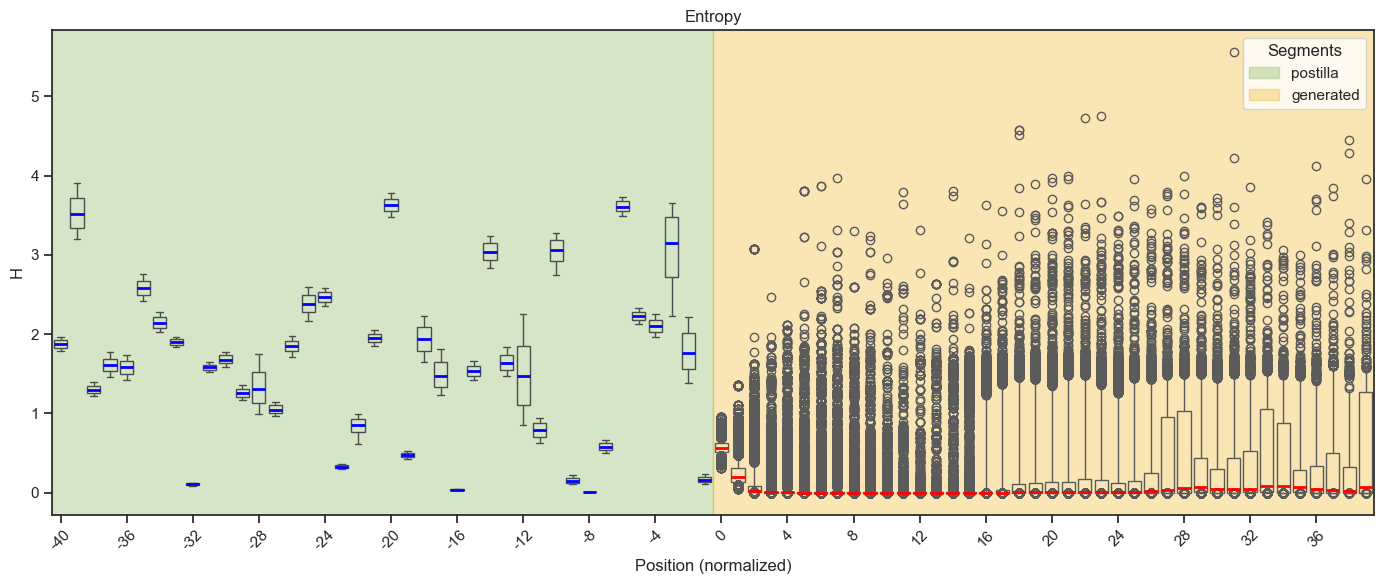

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 40
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [87]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

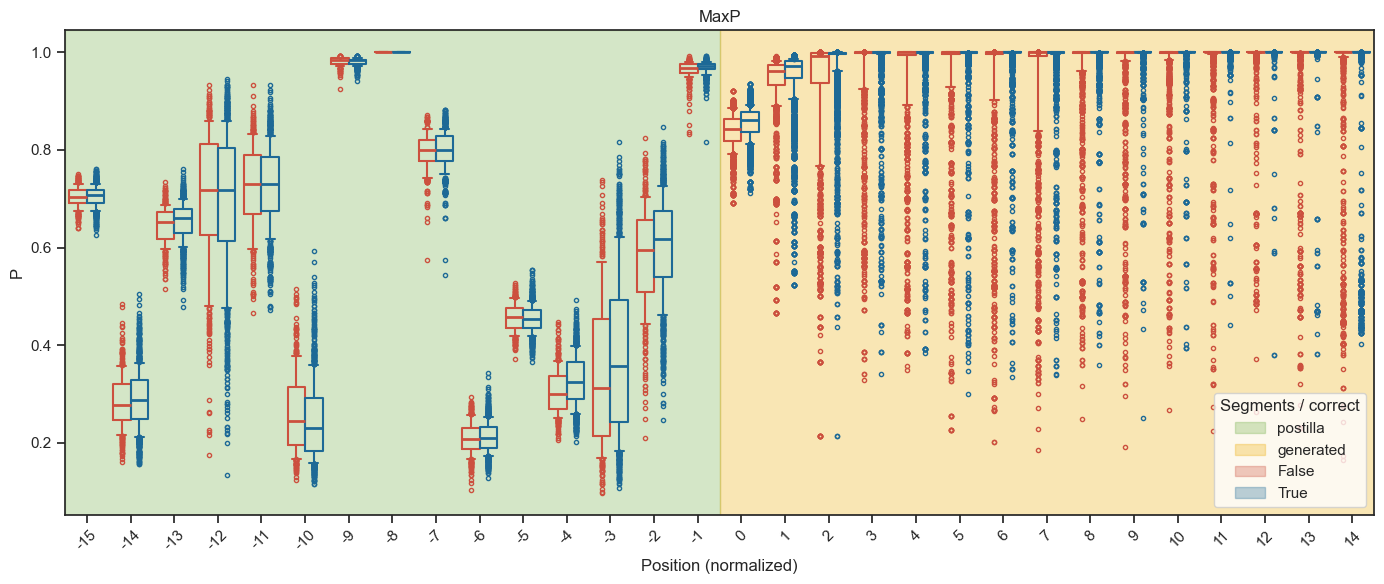

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

subpalette = [palette[7], palette[1]]
sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=subpalette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=subpalette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [89]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

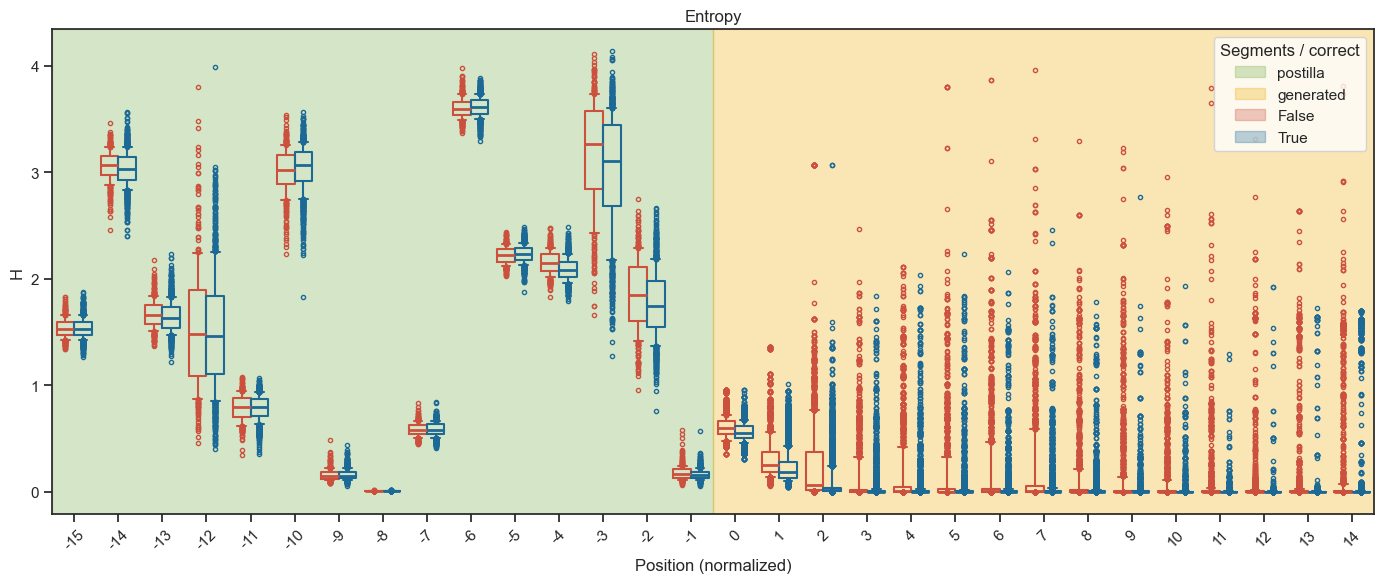

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=subpalette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=subpalette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=subpalette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="upper right")

plt.tight_layout()

plt.show()

99


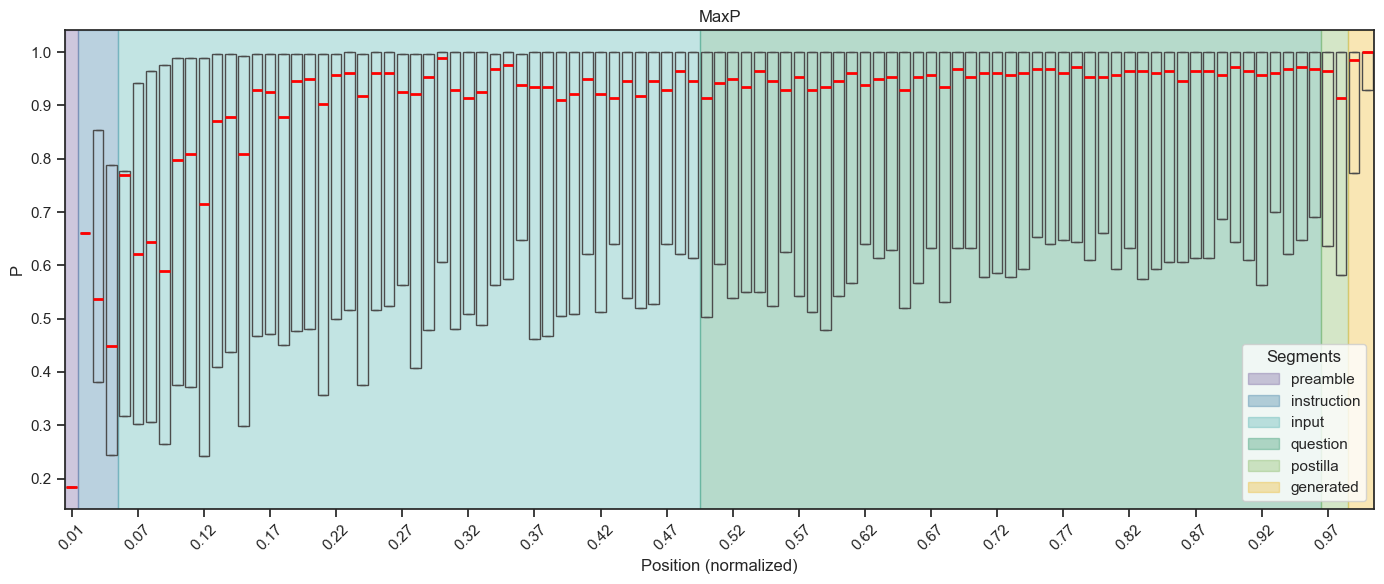

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

99


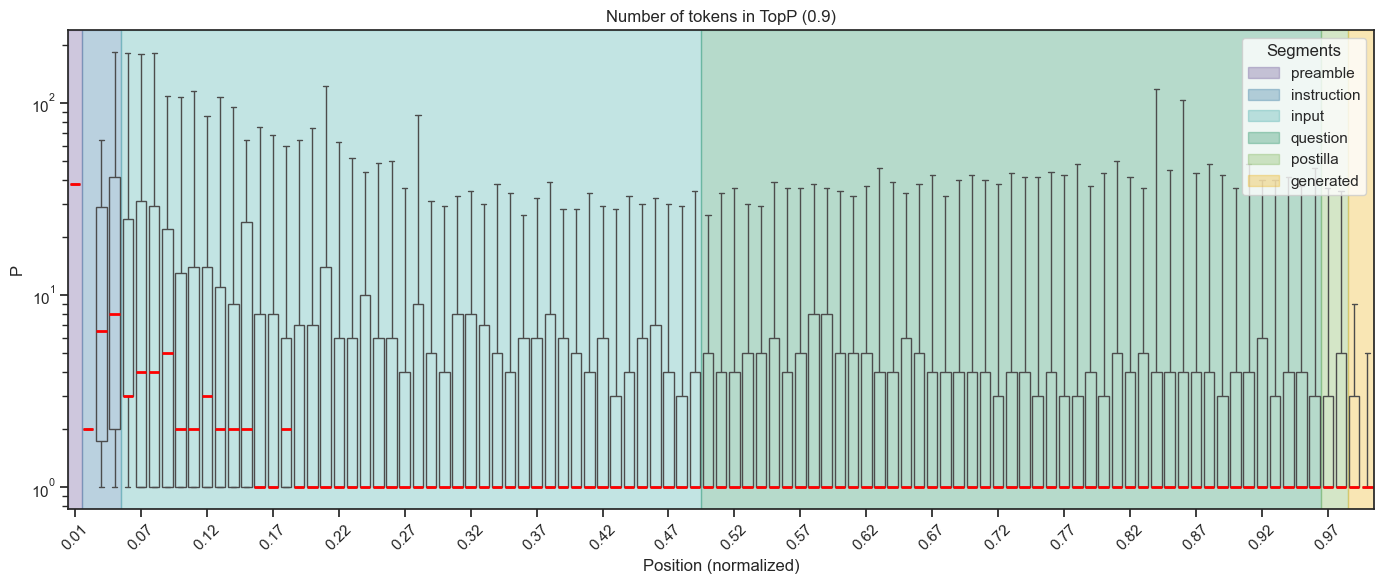

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [135]:
mm = m.copy()

In [140]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [141]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

0.0

In [142]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.0

In [302]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

2119.6445662171286

In [303]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

205685.36468253966

In [304]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

219.45677452623312

### search prompts for which top-p varies

In [305]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [306]:
mv = mm[mm.pid.isin(variators)]

In [307]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

array([1311,  835,  761, ..., 1382,  518,  621])

In [308]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [309]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

array([   0,   12,   14,   17,   19,   23,   30,   32,   34,   41,   49,
         50,   54,   55,   63,   64,   65,   72,   78,   79,   85,   94,
        112,  114,  119,  123,  125,  130,  134,  139,  142,  143,  144,
        146,  147,  148,  149,  150,  153,  159,  160,  162,  163,  169,
        177,  181,  182,  188,  190,  195,  200,  204,  209,  224,  225,
        229,  231,  233,  237,  238,  240,  241,  245,  246,  252,  254,
        257,  265,  266,  273,  283,  297,  300,  302,  318,  320,  322,
        323,  327,  332,  340,  342,  348,  350,  351,  352,  353,  354,
        357,  358,  359,  361,  364,  367,  368,  369,  375,  378,  380,
        382,  384,  402,  404,  412,  417,  422,  423,  442,  444,  446,
        447,  448,  449,  450,  453,  454,  458,  463,  466,  478,  480,
        483,  484,  485,  486,  487,  493,  494,  503,  511,  513,  518,
        521,  523,  530,  531,  536,  550,  553,  558,  580,  581,  590,
        595,  598,  599,  600,  610,  626,  628,  6

In [310]:
set(v1) - set(v2)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 13,
 15,
 16,
 18,
 20,
 21,
 24,
 25,
 33,
 35,
 36,
 37,
 39,
 40,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 51,
 52,
 53,
 66,
 67,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 83,
 84,
 86,
 87,
 93,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 103,
 104,
 105,
 106,
 107,
 108,
 111,
 113,
 115,
 116,
 117,
 118,
 120,
 121,
 122,
 124,
 126,
 127,
 128,
 129,
 131,
 132,
 133,
 135,
 136,
 137,
 138,
 140,
 141,
 151,
 152,
 154,
 155,
 158,
 164,
 165,
 166,
 167,
 168,
 170,
 172,
 173,
 174,
 175,
 176,
 178,
 179,
 180,
 183,
 184,
 189,
 191,
 192,
 193,
 194,
 196,
 197,
 198,
 199,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 226,
 227,
 228,
 232,
 234,
 235,
 236,
 239,
 242,
 243,
 244,
 247,
 248,
 249,
 250,
 251,
 253,
 255,
 258,
 259,
 260,
 261,
 262,
 263,
 268,
 271,
 272,
 276,
 280,
 281,
 282,
 289,
 294,
 295,
 296,
 301,
 303,
 305,
 307,
 313,
 314,
 317,
 319,
 321,
 3

In [311]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

,pid,correct
0,0,0.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
...,...,...
1472,1795,1.0
1473,1796,0.0
1474,1798,1.0
1475,1799,1.0


In [312]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

,pid,correct


In [313]:
m_

,run,pid,tok,area,shape,true_ent,maxp,trans_s,trans_l,logitlens_kl,...,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end,tok_bin,tok_bin_hi,tok_bin_lo
11987,0,1311,1997,generated,2,4.684940e-01,0.888423,-0.088939,-0.118302,"[93.30162811279297, 82.69623565673828, 59.6865...",...,generated,5,19,0.991067,5.000000,0,-19,"(4.98, 5.04]",5.04,4.98
11993,0,1311,1998,generated,2,4.194923e-01,0.893469,-0.100207,-0.112640,"[109.36854553222656, 82.54143524169922, 51.741...",...,generated,5,19,0.991563,5.055556,1,-18,"(5.04, 5.1]",5.10,5.04
11999,0,1311,1999,generated,1,1.317942e-02,0.998416,0.000000,-0.001585,"[142.9993896484375, 118.98223114013672, 113.48...",...,generated,5,19,0.992060,5.111111,2,-17,"(5.1, 5.16]",5.16,5.10
12005,0,1311,2000,generated,1,6.237745e-04,0.999961,0.000000,-0.000039,"[255.99887084960938, 218.9993133544922, 180.99...",...,generated,5,19,0.992556,5.166667,3,-16,"(5.16, 5.22]",5.22,5.16
12011,0,1311,2001,generated,1,2.957347e-08,1.000000,0.000000,0.000000,"[286.0, 225.0, 184.0, 160.0, 146.0, 126.0, 114...",...,generated,5,19,0.993052,5.222222,4,-15,"(5.22, 5.28]",5.28,5.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22329239,0,621,2147,generated,1,1.117797e-08,1.000000,0.000000,0.000000,"[231.0, 200.0, 170.0, 154.0, 127.0, 112.5, 84....",...,generated,5,31,0.995364,5.666667,20,-11,"(5.64, 5.7]",5.70,5.64
22329245,0,621,2148,generated,1,2.710283e-03,0.999805,0.000000,-0.000194,"[232.9960479736328, 201.99574279785156, 133.99...",...,generated,5,31,0.995828,5.700000,21,-10,"(5.64, 5.7]",5.70,5.64
22329251,0,621,2149,generated,1,1.195919e-07,1.000000,0.000000,0.000000,"[169.0, 131.0, 104.0, 96.5, 77.5, 71.5, 63.75,...",...,generated,5,31,0.996291,5.733333,22,-9,"(5.7, 5.76]",5.76,5.70
22329257,0,621,2150,generated,1,4.419462e-05,0.999998,0.000000,-0.000002,"[204.99998474121094, 193.99993896484375, 161.9...",...,generated,5,31,0.996755,5.766667,23,-8,"(5.76, 5.82]",5.82,5.76


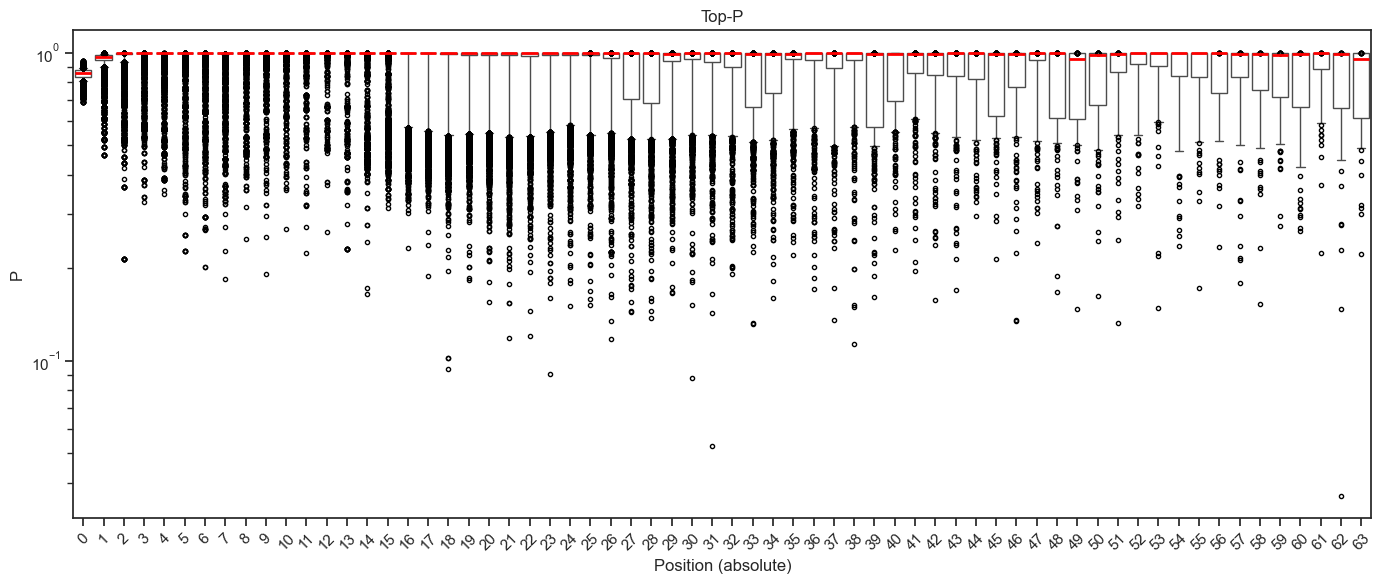

In [314]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

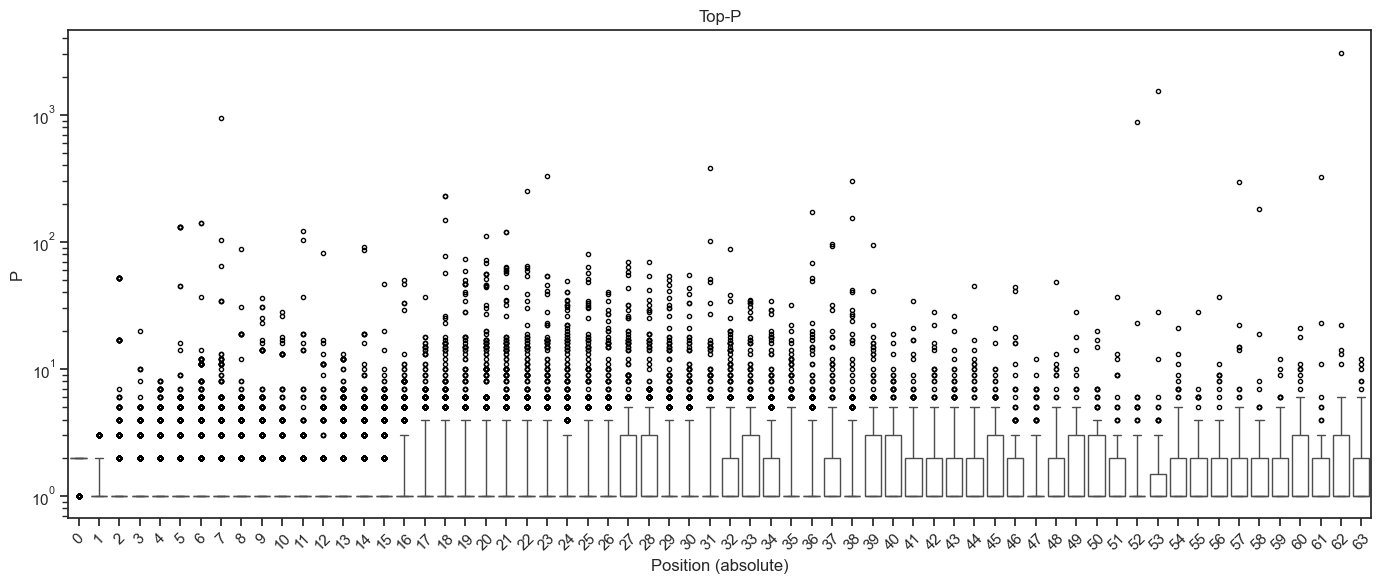

In [315]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

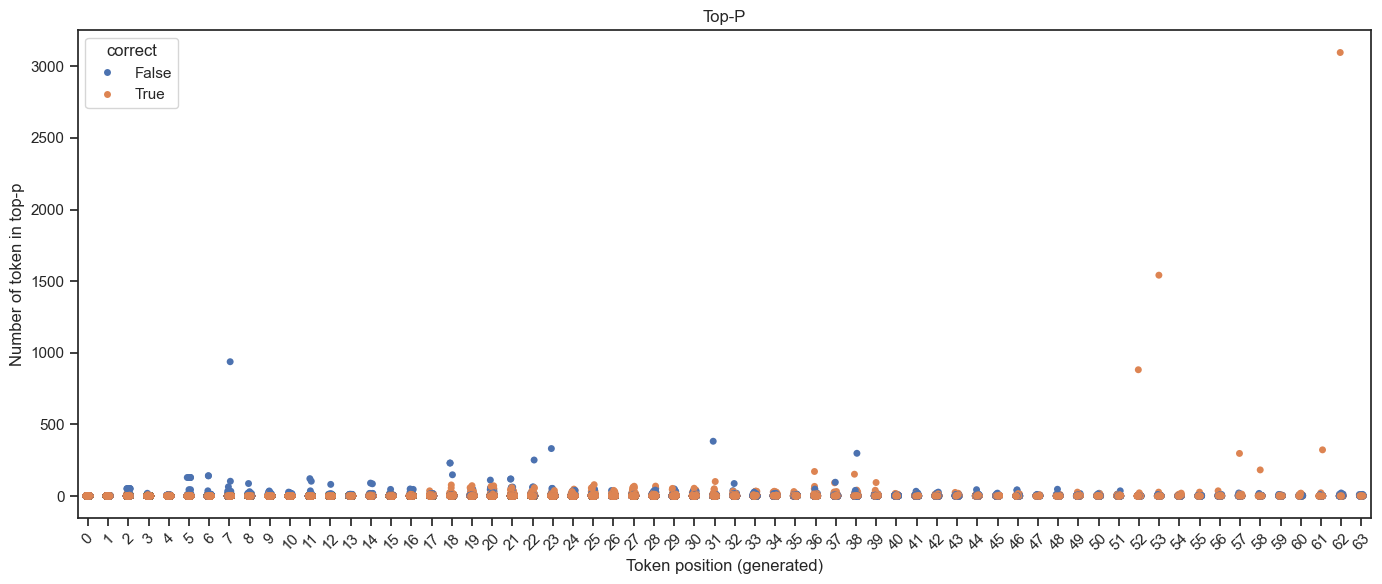

In [316]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

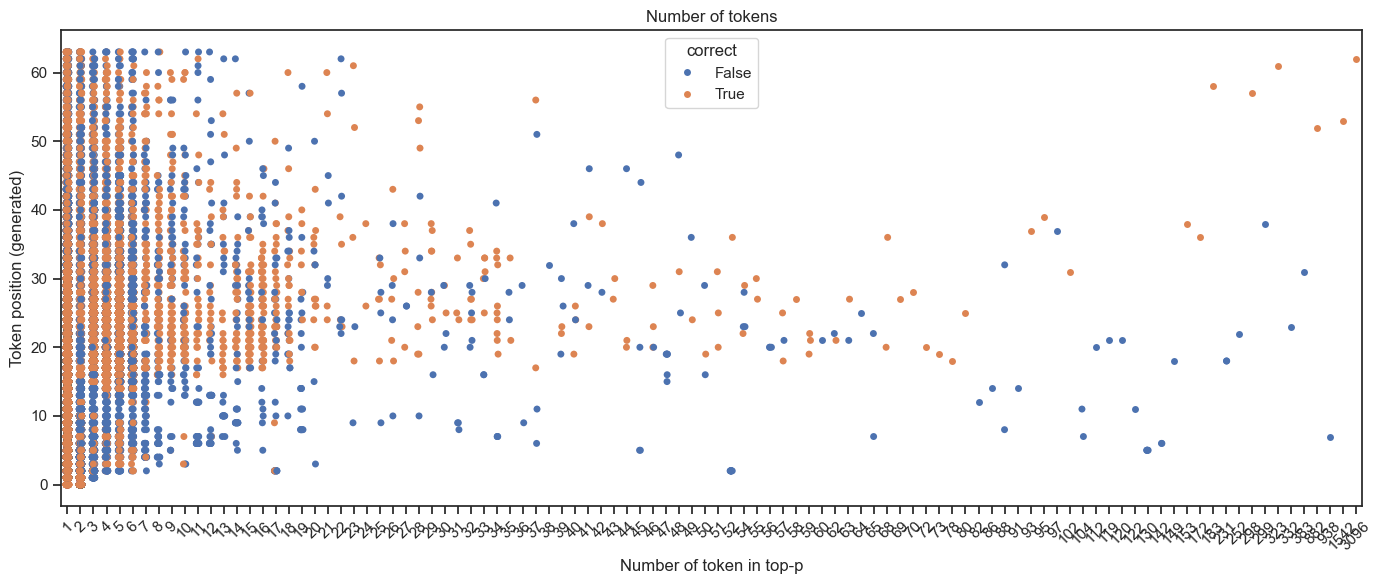

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [320]:
m_.groupby('shape').correct.agg(['count', 'mean'])[:20]

,count,mean
shape,,
1,325889,0.753539
2,20560,0.676800
3,9922,0.734932
4,5333,0.759047
5,9489,0.755506
6,3055,0.632079
7,218,0.454128
8,151,0.523179
9,124,0.693548


In [321]:
m_.groupby('shape').correct.agg(['count', 'mean'])

,count,mean
shape,,
1,325889,0.753539
2,20560,0.676800
3,9922,0.734932
4,5333,0.759047
5,9489,0.755506
...,...,...
383,1,0.000000
882,1,1.000000
938,1,0.000000


In [322]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

shape
1       0.867575
2       0.054734
3       0.026414
4       0.014197
5       0.025261
          ...   
383     0.000003
882     0.000003
938     0.000003
1542    0.000003
3096    0.000003
Name: correct, Length: 100, dtype: float64

In [323]:
mm[mm.segment=='generated'].true_ent.describe()

count    3.756320e+05
mean     1.696766e-01
std      4.089991e-01
min      2.024589e-11
25%      3.153645e-05
50%      9.615702e-04
75%      6.121950e-02
max      6.877833e+00
Name: true_ent, dtype: float64

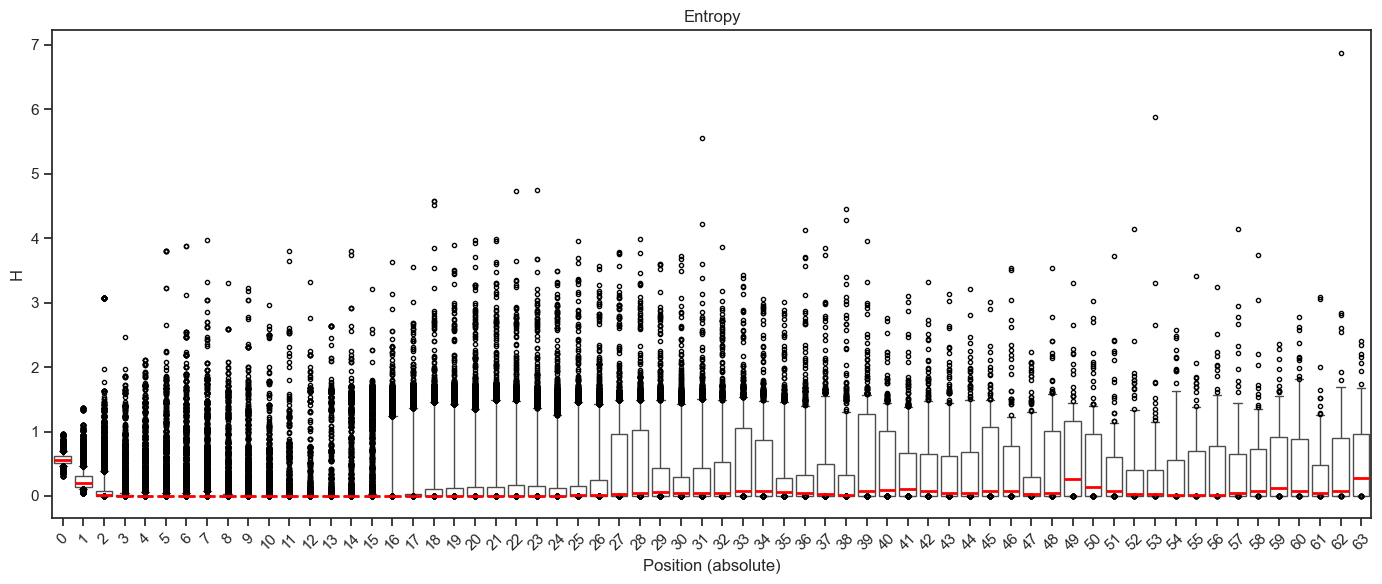

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

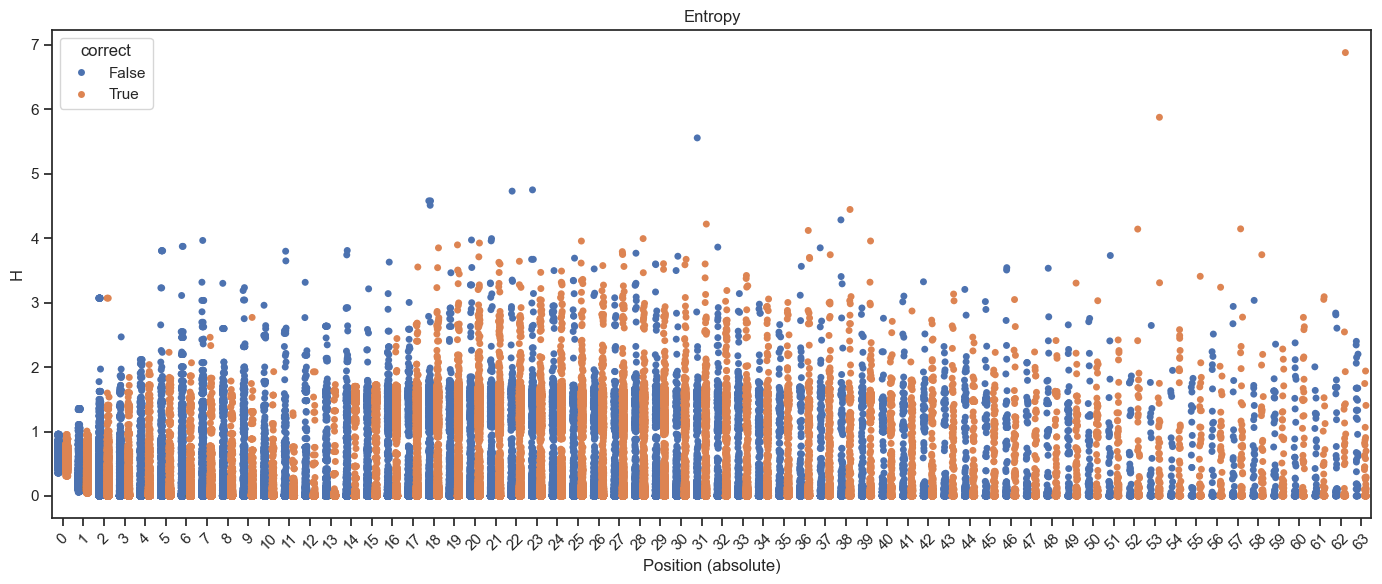

In [325]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()